# Round 6: Feature Engineering batch

I'm getting a little impatient to be honest. It seems like a lot of the current features mostly add noise. 

We did have good success with adding a title.  I think I want a new set of features that might better describe relationships between our current features and who lived or died. I recently saw a notebook on Kaggle that intrigued me, so I'm going to take a look at replicating his/her thought process while looking at data.

First I want to see what age groups had higher death rates. Because I don't really know what to expect, I'm going to start pretty granular by separating the age groups by 5 year increments:

In [410]:
# data handling
import pandas as pd
import numpy as np

# data vis
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning stuff
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing as pre
from sklearn import metrics

In [411]:
# Set-up default visualization parameters:
context_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}

mpl.rcParams['figure.figsize'] = (12, 8)
sns.set_context("paper", rc=context_dict)
sns.set_style("whitegrid")

In [412]:
# Get training data
train_df = pd.read_csv('data/train.csv')
# Fill in missing ages with average:
train_df.loc[train_df.Age.isnull(), 'Age'] = train_df.Age.mean()
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [413]:
# Let's get family size of each passenger:
train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1
train_df.FamilySize.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [414]:
# Let's categorize who was alone:
train_df['Alone'] = train_df.FamilySize.apply(lambda x: 1 if x==1 else 0)

In [415]:
# Title
train_df['Title'] = train_df.Name.str.extract(r'([a-zA-Z]+)\.')

### Less obvious classifications:

Now that we have added a few categories that might be fairly obvious, or at least easier to figure out, let's get into a little finer detail. We will start by creating a function that dumps continuous data into evenly spaced bins, and then analyze the distribution of deaths over those bins:

In [416]:
def bin_dump(data, increment):
    if data <= increment:
        return f'0 - {increment}'
    if data % increment == 0:
        return f'{data - increment} - {data}'
    else: 
        m = data % increment
        a = data - m
        b = data + (increment - m)
        return f'{a} - {b}'

In [417]:
# Create "AgeGroup" by binning age by increments of 3:
train_df['AgeGroup'] = train_df.apply(lambda x: bin_dump(x.Age, 3), axis=1)

Now that we have created our bins of age groups in a fairly granular way by using 5 year increments, let's see what percentage of each age group died. This will give us a clue as to how we should make our final categorizations of age groups. We will again create a re-usable function to do this:

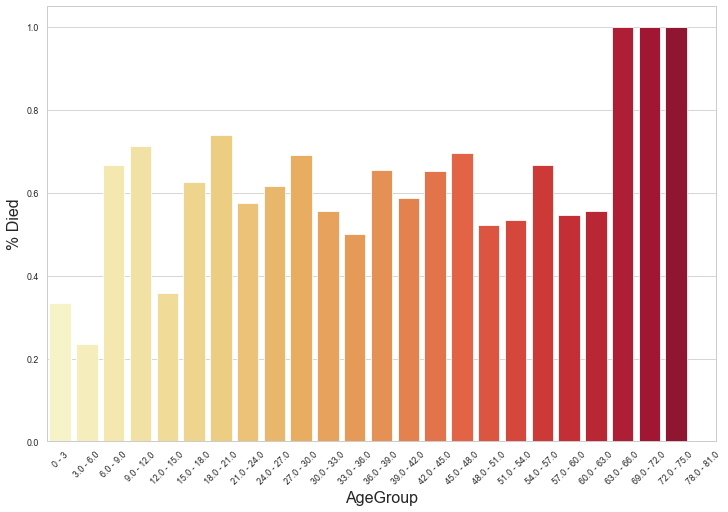

In [418]:
# X is the predictive variable and Y is what we want to predict. percent_what is just the y label
# you want. In this case "died" is appropriate. If you want "lived", change the percentage calculation
# from 1-x/total to x/total.
def plot_dists(X, Y, input_df, percent_what):

    # Get the total number of people in each group
    totals = input_df.loc[:,X].value_counts()
    totals.name = 'Totals'
    
    # Begin building data-frame to return:
    # parse first part of range for each value range. This will be used as our index and to sort.
    df = pd.Series(totals.index).str.extract(r'([0-9]+)').astype('int64')
    df.columns=['index']
    
    # Get value ranges, this will be the a column in our data frame, and a good candidate for x axis ticks 
    values = pd.Series(totals.index, name=X)
      
    # for each value group, find out what percentage of the dependent class is equal to 0.
    percentages = []
    for group, total in zip(totals.index, totals):
        x = input_df.loc[(input_df[X] == group)&(input_df[Y] == 1), Y].sum()
        percent = 1 - x/total
        percentages.append(percent)
    
    # convert list to Series for concatenation to dataframe
    percentages = pd.Series(percentages, name='Percentages')
    
    #
    totals.index = df.index
    
    # create final dataframe
    df = pd.concat([df, values, totals, percentages], axis=1).set_index('index').sort_index(axis=0)
    
    # Plot the results:
    ax = sns.barplot(x=X, y='Percentages', data=df, palette="YlOrRd")
    ax.set_xlabel(X)
    ax.set_ylabel(f"% {percent_what}")
    plt.xticks(rotation=45)
    plt.show()
        
    return df

df = plot_dists('AgeGroup', 'Survived',train_df, 'Died')

From the graph of our age groups, it looks like there were more deaths in the older folks and less deaths in those younger than 6 years old. The rest of the age groups seem fairly well distributed with the outlier being the 12-15 year olds.

Because of this, I want to create a new set of categories "<15" and ">60"

In [419]:
train_df['<6'] = train_df['Age'].apply(lambda x: 1 if x <=6 else 0)
train_df['>63'] = train_df['Age'].apply(lambda x: 1 if x > 63 else 0)

__Next__, I want to use the same technique and the functions we developed to look at our other continuous data, namely Fare. 

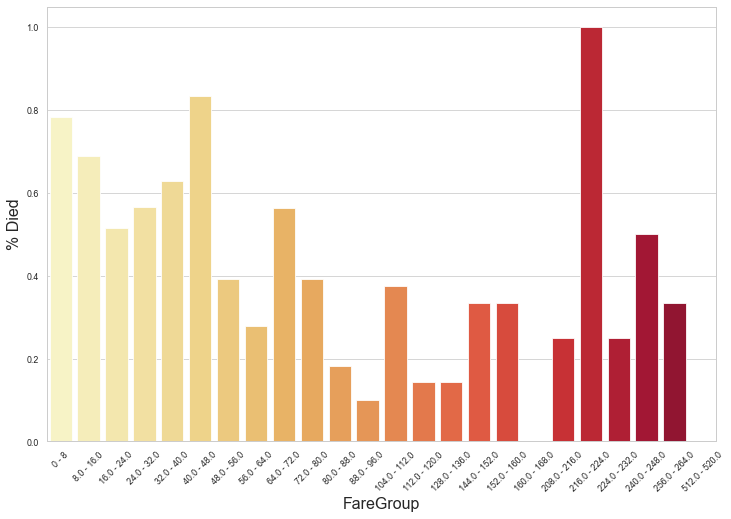

In [420]:
train_df['FareGroup'] = train_df.apply(lambda x: bin_dump(x.Fare, 8), axis = 1)
df = plot_dists('FareGroup', 'Survived', train_df, 'Died')

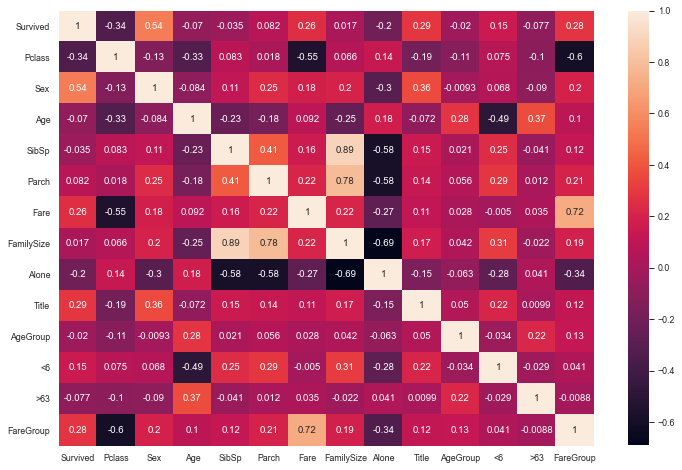

In [421]:
train_df.FareGroup, codes = pd.factorize(train_df.FareGroup)
train_df.AgeGroup, codes = pd.factorize(train_df.AgeGroup)
train_df.Title, codes = pd.factorize(train_df.Title)
train_df.Alone, codes = pd.factorize(train_df.Alone)
train_df.Sex, codes = pd.factorize(train_df.Sex)

train_df.set_index('PassengerId', inplace=True)

sns.heatmap(train_df.corr(), annot=True)

In [422]:
cont = ['FareGroup', 'Age', 'FamilySize', 'Fare']
#continuous
train_df[cont] = pre.scale(train_df[cont], copy=False)
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,AgeGroup,<6,>63,FareGroup
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,-0.592481,1,0,A/5 21171,-0.502445,NaN,S,0.059160,0,0,0,0,0,-0.922595
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.638789,1,0,PC 17599,0.786845,C85,C,0.059160,0,1,1,0,0,-0.697010
3,1,3,"Heikkinen, Miss. Laina",1,-0.284663,0,0,STON/O2. 3101282,-0.488854,NaN,S,-0.560975,1,2,2,0,0,-0.922595
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.407926,1,0,113803,0.420730,C123,S,0.059160,0,1,3,0,0,-0.471425
5,0,3,"Allen, Mr. William Henry",0,0.407926,0,0,373450,-0.486337,NaN,S,-0.560975,1,0,3,0,0,-0.245840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,-0.207709,0,0,211536,-0.386671,NaN,S,-0.560975,1,5,2,0,0,-0.245840
888,1,1,"Graham, Miss. Margaret Edith",1,-0.823344,0,0,112053,-0.044381,B42,S,-0.560975,1,2,10,0,0,0.205331
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,0.000000,1,2,W./C. 6607,-0.176263,NaN,S,1.299429,0,2,4,0,0,-0.020255


In [423]:
# Split data again. We should get the same split as last time by using the same random seed:
np.random.seed(333)

X = train_df.drop(['Survived'], axis=1)
Y = train_df.Survived

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.2)

x_train.sort_values(by='PassengerId').head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,AgeGroup,<6,>63,FareGroup
PassengerId,,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,-0.592481,1,0,A/5 21171,-0.502445,NaN,S,0.059160,0,0,0,0,0,-0.922595
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.638789,1,0,PC 17599,0.786845,C85,C,0.059160,0,1,1,0,0,-0.697010
3,3,"Heikkinen, Miss. Laina",1,-0.284663,0,0,STON/O2. 3101282,-0.488854,NaN,S,-0.560975,1,2,2,0,0,-0.922595
5,3,"Allen, Mr. William Henry",0,0.407926,0,0,373450,-0.486337,NaN,S,-0.560975,1,0,3,0,0,-0.245840
7,1,"McCarthy, Mr. Timothy J",0,1.870059,0,0,17463,0.395814,E46,S,-0.560975,1,0,5,0,0,-0.471425
11,3,"Sandstrom, Miss. Marguerite Rut",1,-1.977659,1,1,PP 9549,-0.312172,G6,S,0.679295,0,2,8,1,0,-0.020255
12,1,"Bonnell, Miss. Elizabeth",1,2.177876,0,0,113783,-0.113846,C103,S,-0.560975,1,2,9,0,0,0.205331
14,3,"Andersson, Mr. Anders Johan",0,0.715743,1,5,347082,-0.018709,NaN,S,3.159833,0,0,1,0,0,0.205331
15,3,"Vestrom, Miss. Hulda Amanda Adolfina",1,-1.208115,0,0,350406,-0.490280,NaN,S,-0.560975,1,2,7,0,0,-0.922595


In [424]:
# drop name, cabin, ticket and embarked
for item in ('Cabin', 'Ticket', 'Embarked', 'Name', 'Age', 'SibSp', 'Parch', 'FamilySize', 'AgeGroup'):
    x_train = x_train.drop([item], axis=1)
    x_test = x_test.drop([item], axis=1)
    x_valid = x_valid.drop([item], axis=1)

# see if classes were droped:
x_train 

,Pclass,Sex,Fare,Alone,Title,<6,>63,FareGroup
PassengerId,,,,,,,,
294,3,1,-0.470230,1,2,0,0,-0.245840
426,3,0,-0.502445,1,0,0,0,-0.922595
499,1,1,2.402990,0,1,0,0,0.882086
91,3,0,-0.486337,1,0,0,0,-0.245840
227,2,0,-0.437007,1,0,0,0,-0.245840
...,...,...,...,...,...,...,...,...
147,3,0,-0.491456,1,0,0,0,-0.922595
762,3,0,-0.504962,1,0,0,0,-0.922595
835,3,0,-0.481304,1,0,0,0,-0.245840


In [425]:
# A function for tracking the performance of different models:
def evaluate(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    eval_dict = metrics.classification_report(y_valid, y_pred, 
                                              labels=[0,1], 
                                              target_names=['Died', 'Survived'],
                                              output_dict=True)
    prob_array = model.predict_proba(x_valid)
    
    fpr, tpr, huh = metrics.roc_curve(y_valid, model.predict_proba(x_valid)[:,1])
    auc = metrics.auc(fpr, tpr)
    eval_dict['AUC'] = auc
    eval_dict['Classifier'] = model
    
    return eval_dict

# a function to pretty print our dictionary of metrics:
def pprint(web, level=0):
    for k,v in web.items():
        if isinstance(v, dict):
            print('\t'*level, f'{k}: ')
            level += 1
            pprint(v, level)
            level -= 1
        else:
            print('\t'*level, k, ": ", v)

In [426]:
result = evaluate(linear_model.LogisticRegression())
pprint(result)

 Died: 
	 precision :  0.8295454545454546
	 recall :  0.8295454545454546
	 f1-score :  0.8295454545454547
	 support :  88
 Survived: 
	 precision :  0.7272727272727273
	 recall :  0.7272727272727273
	 f1-score :  0.7272727272727273
	 support :  55
 accuracy :  0.7902097902097902
 macro avg: 
	 precision :  0.7784090909090909
	 recall :  0.7784090909090909
	 f1-score :  0.778409090909091
	 support :  143
 weighted avg: 
	 precision :  0.7902097902097902
	 recall :  0.7902097902097902
	 f1-score :  0.7902097902097903
	 support :  143
 AUC :  0.8350206611570248
 Classifier :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
